In [2]:
import numpy as np
import scipy as sp
from scipy.linalg import norm, null_space
from scipy.optimize import minimize
from xmps.spin import paulis, U4
def merge(A, B):
    # -A- -B-  ->  -A-B-
    #  |   |        ||
    return np.tensordot(A, B, [2, 1]).transpose([0, 2, 1, 3]).reshape(2*A.shape[0], 2, 2)
N = 4
U = np.linalg.qr(np.random.randn(N, N)+1j*np.random.randn(N, N))[0]
No = U@np.diag(np.random.randn(N)+1j*np.random.randn(N))@U.conj().T

z = np.array([1, 0])
z = np.kron(z, z)
def sv_min(mat): return minimize(lambda v: -(z@U4(-v)@mat.conj().T@mat@U4(v)@z).real, np.random.randn(15))

In [122]:
def put_env_on_left_site(q, ret_n=False):
    # Take a matrix q (2x2) and create U such that 
    # (right 0-|---|--0
    #          | u |        =  q_{ij}
    # (left) i-|---|--j 
    q = q.T
    a, b, c, d = q.reshape(-1)
    n = np.sqrt(np.abs(a)**2+ np.abs(c)**2+ np.abs(b)**2+ np.abs(d)**2)
    guess = np.array([[a, c.conj(), b, d.conj()], [c, -a.conj(), d, -b.conj()]])/n
    orth = null_space(guess).conj().T
    A = np.concatenate([guess, orth], axis=0)
    A = cirq.unitary(cirq.SWAP)@A
    if ret_n:
        return A, n
    else:
        return A
def get_env_off_left_site(A):
    z = np.array([1, 0])
    return np.tensordot(np.tensordot(A.reshape(2, 2, 2, 2), z, [3, 0]), z, [1, 0]).T

def put_env_on_right_site(q, ret_n=False):
    q = q
    a, b, c, d = q.reshape(-1)
    n = np.sqrt(np.abs(a)**2+ np.abs(c)**2+ np.abs(b)**2+ np.abs(d)**2)
    guess = np.array([[a, b, d.conj(), -c.conj()], [c, d, -b.conj(), a.conj()]])/n
    orth = null_space(guess).conj().T
    A = np.concatenate([guess, orth], axis=0)
    #A = cirq.unitary(cirq.SWAP)@A
    if ret_n:
        return A, n
    else:
        return A

def get_env_off_right_site(A):
    z = np.array([1, 0])
    return np.tensordot(np.tensordot(A.reshape(2, 2, 2, 2), z, [2, 0]), z, [0, 0])


N = 50
for _ in range(50):
    q = np.random.randn(2, 2)+1j*np.random.randn(2, 2)
    assert np.allclose(get_env_off_left_site(np.prod(put_env_on_left_site(q, ret_n=True))), q)
    assert np.allclose(get_env_off_right_site(np.prod(put_env_on_right_site(q, ret_n=True))), q)
    U = put_env_on_left_site(q)
    V = put_env_on_right_site(q)
    assert np.allclose(V.conj().T@V, np.eye(U.shape[0]))
    assert np.allclose(U.conj().T@U, np.eye(U.shape[0]))
    
for _ in range(N):
    A = iMPS().random(2, 2).left_canonicalise()[0]
    B = iMPS().random(2, 2).left_canonicalise()[0]#np.tensordot(expm(-1j*Z*dt), A, [1, 0])

    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    x, r = Map(merge(A, A), merge(B, B)).right_fixed_point()
    x_, l = Map(merge(A, A), merge(B, B)).left_fixed_point()
    L = put_env_on_right_site(l)
    R = put_env_on_left_site(r)
    assert np.allclose(get_env_off_left_site(put_env_on_left_site(r)), r)
    assert np.allclose(get_env_off_right_site(put_env_on_right_site(l)), l)
    U = put_env_on_left_site(r)
    V = put_env_on_right_site(l)
    assert np.allclose(V.conj().T@V, np.eye(U.shape[0]))
    assert np.allclose(U.conj().T@U, np.eye(U.shape[0]))

In [8]:
% autoreload 2
from xmps.iMPS import iMPS, Map, TransferMatrix
A = iMPS().random(2, 2).left_canonicalise()
B = iMPS().random(2, 2).left_canonicalise()
E = Map(A[0], B[0]).asmatrix()
xs, L = np.linalg.eig(E.conj().T)
xs_, R = np.linalg.eig(E)

UsageError: Line magic function `%autoreload` not found.


In [420]:
np.abs(np.linalg.eig(No)[0])**2

array([3.96022439, 0.72454277, 1.12865704, 1.15355882])

In [421]:
sv_min(E).fun

-0.9870528934194964

In [429]:
from functools import reduce
def krylov(A, v, k):
    As = [v]
    for _ in range(k):
        As.append(A@As[-1]/norm(A@As[-1]))
    return np.array(As)

In [451]:
N = 100
np.abs(E@krylov(E, np.random.randn(4), N)[-1]/krylov(E, np.random.randn(4), N)[-1])[0]

0.7690150868558495

In [463]:
from scipy.optimize import minimize
from scipy.linalg import norm
import cirq
from qmps.represent import ShallowFullStateTensor, Environment
from qmps.tools import unitary_to_tensor, tensor_to_unitary
from xmps.tensor import rotate_to_hermitian
from qmps.ground_state import Hamiltonian
from scipy.linalg import expm
from xmps.spin import paulis
from tqdm import tqdm_notebook

def gate(v, symbol='U'):
    #return ShallowCNOTStateTensor(2, v[:-1])
    return ShallowFullStateTensor(2, v, symbol)
    #return FullStateTensor(U4(v))



def obj(p_, A, WW):
    p, rs = p_[:15], p_[15:]
    
    B = iMPS([unitary_to_tensor(cirq.unitary(gate(p)))]).left_canonicalise()[0]
    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    r = rotate_to_hermitian((rs[:4]+1j*rs[4:]).reshape(2, 2))
    r /= np.sqrt(np.trace(r.conj().T@r))
    l = r
    
    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(l.conj().T), 'L')
    
    W = Environment(WW, 'W')

    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               W(*qbs[2:4]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])

    s = cirq.Simulator(dtype=np.complex128)
    return -np.abs(s.simulate(C).final_state[0])*2

from xmps.iOptimize import find_ground_state
g0, g1 = 1.5, 0.2
A, es = find_ground_state(Hamiltonian({'ZZ':-1, 'X':g0}).to_matrix(), 2, tol=1e-2, noisy=True)
print(es[-1])
N = 23

T = np.linspace(0, 10, 100)
dt = T[1]-T[0]
res = minimize(obj, np.random.randn(N), 
               (A[0], np.eye(4)), 
               method='Nelder-Mead',
               options={'disp':True})
params = res.x

WW = expm(-1j*Hamiltonian({'ZZ':-1, 'X':g1}).to_matrix()*2*dt)
ps = [params]
ops = paulis(0.5)
evs = []
les = []
errs = [res.fun]
for _ in tqdm_notebook(T):
    A_ = iMPS([unitary_to_tensor(cirq.unitary(gate(params)))]).left_canonicalise()
    evs.append(A_.Es(ops))
    les.append(A_.overlap(A))
    res = minimize(obj, params, (A_[0], WW), options={'disp':True})
    params = res.x
    errs.append(res.fun)
    ps.append(params)


  0%|          | 19/5000 [00:00<01:56, 42.60it/s]


(-1.6663834375491906-1.7521241785596813e-17j)


         Current function value: -0.704913
         Iterations: 27
         Function evaluations: 1986
         Gradient evaluations: 79
         Current function value: -0.706794
         Iterations: 51
         Function evaluations: 4334
         Gradient evaluations: 173
         Current function value: -0.706834
         Iterations: 40
         Function evaluations: 2072
         Gradient evaluations: 82
         Current function value: -0.706881
         Iterations: 12
         Function evaluations: 1237
         Gradient evaluations: 49
         Current function value: -0.706892
         Iterations: 20
         Function evaluations: 1537
         Gradient evaluations: 61
         Current function value: -0.706963
         Iterations: 60
         Function evaluations: 3860
         Gradient evaluations: 154
         Current function value: -0.706239
         Iterations: 1
         Function evaluations: 1036
         Gradient evaluations: 41
         Current function value: -0.7062

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.707096
         Iterations: 16
         Function evaluations: 1510
         Gradient evaluations: 60
Optimization terminated successfully.
         Current function value: -0.707097
         Iterations: 14
         Function evaluations: 575
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -0.707104
         Iterations: 3
         Function evaluations: 100
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: -0.707105
         Iterations: 7
         Function evaluations: 300
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: -0.707106
         Iterations: 2
         Function evaluations: 75
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: -0.707106
         Iterations: 2
         Function eval

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.707105
         Iterations: 2
         Function evaluations: 612
         Gradient evaluations: 24


/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.707106
         Iterations: 63
         Function evaluations: 4027
         Gradient evaluations: 160


/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.707105
         Iterations: 27
         Function evaluations: 1962
         Gradient evaluations: 78
         Current function value: -0.707105
         Iterations: 6
         Function evaluations: 787
         Gradient evaluations: 31


/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.707105
         Iterations: 15
         Function evaluations: 1322
         Gradient evaluations: 52
         Current function value: -0.707105
         Iterations: 44
         Function evaluations: 2612
         Gradient evaluations: 104
         Current function value: -0.707105
         Iterations: 43
         Function evaluations: 2165
         Gradient evaluations: 86
         Current function value: -0.707105
         Iterations: 9
         Function evaluations: 711
         Gradient evaluations: 28
         Current function value: -0.707105
         Iterations: 12
         Function evaluations: 1489
         Gradient evaluations: 59
         Current function value: -0.707105
         Iterations: 0
         Function evaluations: 487
         Gradient evaluations: 19


/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.707105
         Iterations: 7
         Function evaluations: 914
         Gradient evaluations: 36
         Current function value: -0.707105
         Iterations: 3
         Function evaluations: 437
         Gradient evaluations: 17
         Current function value: -0.707105
         Iterations: 6
         Function evaluations: 739
         Gradient evaluations: 29


/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.707105
         Iterations: 5
         Function evaluations: 789
         Gradient evaluations: 31
         Current function value: -0.707105
         Iterations: 2
         Function evaluations: 662
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -0.707105
         Iterations: 5
         Function evaluations: 200
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: -0.707105
         Iterations: 2
         Function evaluations: 75
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: -0.707105
         Iterations: 2
         Function evaluations: 75
         Gradient evaluations: 3
         Current function value: -0.707105
         Iterations: 13
         Function evaluations: 1312
         Gradient evaluations: 52
         Current function value:

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.707105
         Iterations: 26
         Function evaluations: 1795
         Gradient evaluations: 71
         Current function value: -0.707105
         Iterations: 10
         Function evaluations: 762
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: -0.707105
         Iterations: 27
         Function evaluations: 1150
         Gradient evaluations: 46
         Current function value: -0.707105
         Iterations: 11
         Function evaluations: 787
         Gradient evaluations: 31
         Current function value: -0.707105
         Iterations: 23
         Function evaluations: 1318
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: -0.707105
         Iterations: 12
         Function evaluations: 650
         Gradient evaluations: 26
         Current function value: -0.707105
         Iterat

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
Divide-by-zero encountered: rhok assumed large
         Current function value: -0.707105
         Iterations: 15
         Function evaluations: 1187
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: -0.707105
         Iterations: 23
         Function evaluations: 975
         Gradient evaluations: 39


/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.707105
         Iterations: 2
         Function evaluations: 484
         Gradient evaluations: 19
         Current function value: -0.707105
         Iterations: 10
         Function evaluations: 1012
         Gradient evaluations: 40


/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large


/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.707105
         Iterations: 16
         Function evaluations: 1783
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: -0.707105
         Iterations: 16
         Function evaluations: 775
         Gradient evaluations: 31
         Current function value: -0.707105
         Iterations: 11
         Function evaluations: 837
         Gradient evaluations: 33
         Current function value: -0.707105
         Iterations: 15
         Function evaluations: 1237
         Gradient evaluations: 49
         Current function value: -0.707105
         Iterations: 32
         Function evaluations: 1915
         Gradient evaluations: 76
Optimization terminated successfully.
         Current function value: -0.707105
         Iterations: 23
         Function evaluations: 925
         Gradient evaluations: 37
Optimization terminated successfully.
         Current fun

In [4]:
import matplotlib.pyplot as plt
from scipy.linalg import norm
from qmps.represent import StateGate
%matplotlib notebook

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


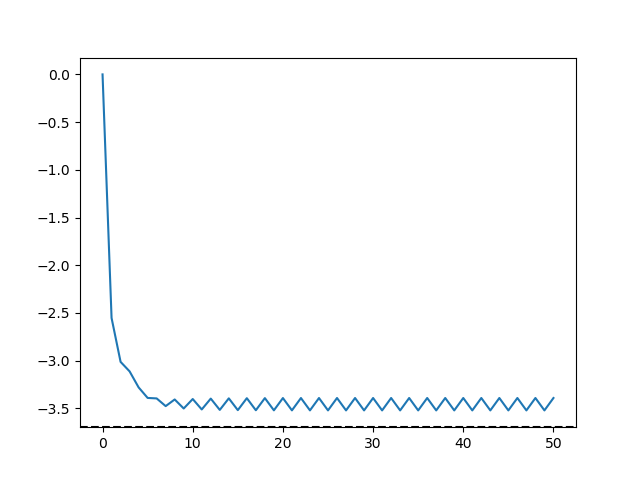

In [703]:
def ev_min(M, max_iters=50, tol = 1e-3):
    q = M.shape[0]
    v = np.random.randn(2*q)
    vs = [v/norm(v)]
    conv = [0]

    for _ in range(max_iters):
        def x(θ):
            #θ[-1] = θ[-2] = θ[-3] = θ[-4] = θ[-5]= 0
            return cirq.unitary(StateGate(θ))@np.array([0, 0, 0, 1])
        
        def overlap(x, y, M=None):
            q = x.shape[0]
            M = np.eye(int(q/2)) if M is None else M
            xx = (x[:int(q/2)]+1j*x[int(q/2):])
            yy = (y[:int(q/2)]+1j*y[int(q/2):])
            xx/=norm(xx)
            yy/=norm(yy)
            return -np.abs(xx.conj().T@M@yy)
        
        def c_overlap(x, y, M=None):
            q = x.shape[0]
            M = np.eye(int(q/2)) if M is None else M
            xx = x
            yy = y
            xx/=norm(xx)
            yy/=norm(yy)
            return -np.abs(xx.conj().T@M@yy)  
        
        res = minimize(lambda θ: c_overlap(x(θ), x(vs[-1]), M), np.random.randn(6))
        vs.append(res.x)
        conv.append(c_overlap(x(vs[-2]), x(vs[-1]), M))
        if np.abs(conv[-1]-conv[-2])<tol:
            break
        
    return conv, vs[-1]

N = 4
#M = np.random.randn(N, N)+1j*np.random.randn(N, N)
#M = M+M.conj().T+1e-1*(M-M.conj().T)
#M/=norm(M)
#print(norm((M@M.conj().T-M.conj().T@M)))
plt.figure()
plt.plot(ev_min(M)[0])
plt.axhline(-max(np.abs(np.linalg.eig(M)[0])), 0, 1, c='black', linestyle='--')

In [198]:
def left_gate(rs):
    r = (rs[:4]+1j*rs[4:]).reshape(2, 2)
    r /= np.sqrt(np.trace(r.conj().T@r))
    return Environment(put_env_on_left_site(r), 'R')
def right_gate(rs):
    r = (rs[:4]+1j*rs[4:]).reshape(2, 2)
    r /= np.sqrt(np.trace(r.conj().T@r))
    return Environment(put_env_on_right_site(r.conj().T), 'R')

def largest_eig_variational(p, p_, max_iters=20, tol=1e-3):
    """
    """
    A = iMPS([unitary_to_tensor(cirq.unitary(gate(p)))]).left_canonicalise()[0]
    B = iMPS([unitary_to_tensor(cirq.unitary(gate(p_)))]).left_canonicalise()[0]
    x, r = Map(A, B).left_fixed_point()    
    
    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')
    rs = [np.random.randn(8)]
    conv = []
    
    for k in range(max_iters):
        def obj(rs, rs_):
            R = left_gate(rs_)
            L = right_gate(rs)

            qbs = cirq.LineQubit.range(5)
            C = cirq.Circuit.from_ops([cirq.H(qbs[2]), cirq.CNOT(*qbs[2:4]),
                                       U(*qbs[1:3]),
                                       L(*qbs[0:2]),
                                       R(*qbs[3:5]),
                                       cirq.inverse(U_)(*qbs[1:3]),
                                       cirq.CNOT(*qbs[2:4]), cirq.H(qbs[2])])
            

            s = cirq.Simulator(dtype=np.complex128)
            return -np.abs(s.simulate(C).final_state[0])*2
        res = minimize(lambda x: obj(x, rs[-1]), np.random.randn(8), tol=1e-4)
        rs.append(res.x)
        conv.append(res.fun)
        
        if k>1 and np.abs(conv[-1]-conv[-2])<tol and np.abs(conv[-2]-conv[-3])<tol:
            break    
    return x, -np.array(conv)[1:], rs

In [194]:
C = cirq.Circuit.from_ops([cirq.decompose_once(LeftFullGate(randn(6))(*cirq.LineQubit.range(2)))])
print(C.to_text_diagram(transpose=True))


0           1
│           │
Rx(-0.254π) Rz(0.007π)
│           │
S^-1        Rx(0.074π)
│           │
│           Rz(-0.427π)
│           │
X───────────@
│           │
│           Rx(-0.603π)
│           │
│           Rz(-0.139π)
│           │


In [329]:
import cirq
from numpy.random import randn
from xmps.iMPS import iMPS, Map
from qmps.represent import unitary_to_tensor, Environment
from qmps.represent import ShallowCNOTStateTensor, ShallowQAOAStateTensor, ShallowFullStateTensor
from qmps.tools import tensor_to_unitary
def gate(v, symbol='U'):
    #return ShallowCNOTStateTensor(2, v)
    #return ShallowQAOAStateTensor(2, v)
    return ShallowFullStateTensor(2, v, symbol)
    #return FullStateTensor(U4(v))
    
class LeftFullGate(cirq.Gate):
    """
    Parametrisation of tr 1 non unitary on right hand site (gate goes on left of diagram). 
    Singular values are np.array([cos(a), sin(a)])"""
    def __init__(self, params, D=2):
        self.params = params
    def _decompose_(self, qubits):
        a, b, c, d, e, f = self.params
        return [cirq.Rx(a*2)(qubits[0]), cirq.inverse(cirq.S(qubits[0])),
                cirq.Rz(b)(qubits[1]), cirq.Rx(c)(qubits[1]), cirq.Rz(d)(qubits[1]),
                cirq.CNOT(qubits[1], qubits[0]),
                cirq.Rx(f)(qubits[1]), cirq.Rz(e)(qubits[1])] 
    def singular_values(self):
        return np.abs(np.array([np.cos(self.params[0]), np.sin(self.params[0])]))
    def num_qubits(self):
        return 2
    
class RightFullGate(cirq.Gate):
    """
    Parametrisation of tr 1 non unitary on left hand site (gate goes on right of diagram). 
    Singular values are np.array([np.sqrt((1-np.sin(a)*np.sin(b))/2), np.sqrt((1+np.sin(a)*np.sin(b))/2)])"""
    def __init__(self, params, D=2):
        self.params = params
    def _decompose_(self, qubits):
        return [cirq.SWAP(*qubits),
                cirq.inverse(LeftFullGate(self.params)(*qubits)),
                cirq.SWAP(*qubits)] 
    def singular_values(self):
        return np.abs(np.array([np.cos(self.params[0]), np.sin(self.params[0])]))
    
    def num_qubits(self):
        return 2
    
N = 30
for _ in range(N):
    a, b, c, d, e, f = x = randn(6)
    L = LeftFullGate(x)(*cirq.LineQubit.range(2))
    U = cirq.unitary(L)
    z = np.array([1, 0])
    v1 = np.linalg.svd(np.tensordot(np.tensordot(U.reshape(2, 2, 2, 2), z, [-2, 0]), z, [0, 0]))[1]
    v2 = np.array([np.abs(np.cos(a)), np.abs(np.sin(a))])
    v2.sort(), v1.sort()
    assert np.allclose(v1, v2)
    
for _ in range(N):
    a, b, c, d, e, f = x = randn(6)
    L = RightFullGate(x)(*cirq.LineQubit.range(2))
    U = cirq.unitary(L)
    z = np.array([1, 0])
    v1 = np.linalg.svd(np.tensordot(np.tensordot(U.reshape(2, 2, 2, 2), z, [-1, 0]), z, [1, 0]))[1]
    v2 = np.array([np.abs(np.cos(a)), np.abs(np.sin(a))])
    v2.sort(), v1.sort()
    assert np.allclose(v1, v2)
    
def largest_eig_variational(p, p_, max_iters=20, tol=1e-3):
    """
    """
    A = iMPS([unitary_to_tensor(cirq.unitary(gate(p)))]).left_canonicalise()[0]
    B = iMPS([unitary_to_tensor(cirq.unitary(gate(p_)))]).left_canonicalise()[0]
    x, r = Map(A, B).left_fixed_point()    
    
    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')
    rs = [np.zeros(6)]
    conv = []
    
    for k in range(max_iters):
        def obj(rs, rs_):
            R = RightFullGate(rs_)
            L = LeftFullGate(rs)

            qbs = cirq.LineQubit.range(5)
            C = cirq.Circuit.from_ops([cirq.H(qbs[2]), cirq.CNOT(*qbs[2:4]),
                                       U(*qbs[1:3]),
                                       L(*qbs[0:2]),
                                       R(*qbs[3:5]),
                                       cirq.inverse(U_)(*qbs[1:3]),
                                       cirq.CNOT(*qbs[2:4]), cirq.H(qbs[2])])
            
            s = cirq.Simulator(dtype=np.complex128)
            return -np.abs(s.simulate(C).final_state[0])*2
        s = np.zeros(2)
        guess = np.array([0.2, *s, 0, *(-s)]) #
        res = minimize(lambda x: obj(x*np.array([1, 0, 1, 0, 1, 0]), rs[-1]), guess)
        rs.append(res.x)
        conv.append(res.fun)
        
        if k>1 and np.abs(conv[-1]-conv[-2])<tol and np.abs(conv[-2]-conv[-3])<tol:
            break    
    return x, -np.array(conv)[1:], rs

In [330]:
%%time
X, Y  = np.random.randn(15), np.random.randn(15)
eps = 3
x, ress, rs = largest_eig_variational(X, Y, max_iters=100, tol=1e-3)

CPU times: user 1min 26s, sys: 4.57 s, total: 1min 30s
Wall time: 1min 35s


<IPython.core.display.Javascript object>


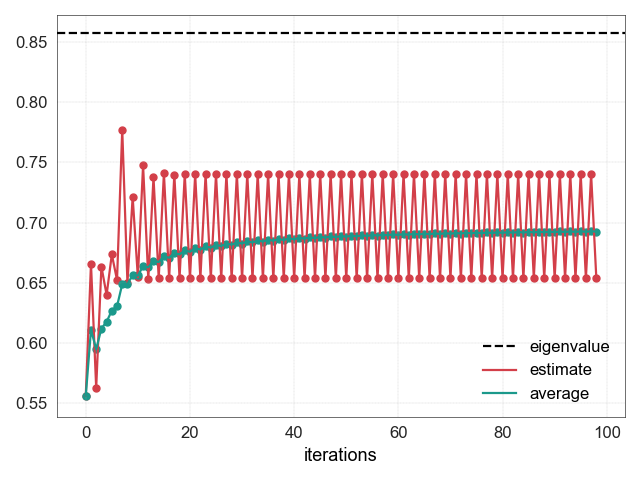

In [331]:
%matplotlib notebook
import matplotlib as mpl
mpl.style.use('pub_fast')
plt.figure()
ts = np.array(list(range(len(ress))))
plt.axhline(np.abs(x), c='black', linestyle = '--', label='eigenvalue')
plt.plot(ts, ress, label='estimate')

plt.scatter(ts, ress, marker='.')
plt.plot(ts, np.cumsum(ress)/np.arange(1, len(ress)+1), label='average')
plt.scatter(ts, np.cumsum(ress)/np.arange(1, len(ress)+1), marker='.')

#plt.ylim([0.0, 1])
plt.xlabel('iterations')
plt.legend()
#plt.savefig('/Users/fergusbarratt/Desktop/eig_convergence.pdf', bbox_inches='tight')

In [322]:
import numpy as np
N = 2
A = randn(N, N)+1j*randn(N, N)
def arnoldi(A, b, n):
    m = A.shape[0]

    h = np.zeros((n + 1, n), dtype=np.complex)
    Q = np.zeros((m, n + 1), dtype=np.complex)

    q = b / np.linalg.norm(b)
    Q[:, 0] = q

    for k in range(n):
        v = A.dot(q)
        for j in range(k + 1):
            h[j, k] = np.dot(Q[:, j].conj(), v)  # <-- Q needs conjugation!
            v = v - h[j, k] * Q[:, j]

        h[k + 1, k] = np.linalg.norm(v)
        eps = 1e-12
        if h[k + 1, k] > eps:
            q = v / h[k + 1, k]
            Q[:, k + 1] = q
        else:
            return Q, h
    return Q, h